CONFIGURATION:
  Wavelength:        1550 nm
  Beam waist:        25.0 mm
  Transmit power:    1.0 W (30.0 dBm)
  Receiver diameter: 30.0 cm
  Weather (for dist):Clear
  Model (for dist):  Kim
  C_n2 (turb):       1e-15 m^-0.6666666666666666

LINK BUDGET SUMMARY: LG_0^0 Beam
Beam Parameters:
  M² = 1.0 (beam quality factor)
  λ = 1550 nm (wavelength)
  w0 = 25.00 mm (initial beam waist)
  z_R = 1266.8 m (Rayleigh range)

Link Parameters:
  P_tx = 1.00 W (30.0 dBm)
  Receiver diameter = 30.0 cm
  Weather Condition = Clear
  Attenuation model = Kim
  alpha_atm = 0.19 dB/km
  C_n2 = 1e-15 m^-2/3 (turbulence)

Distance     w(z)       eta_coll   L_geo      L_atm      L_scint    L_total    P_rx           
[m]          [mm]       [%]        [dB]       [dB]       [dB]       [dB]       [dBm]          
--------------------------------------------------------------------------------------------------------------
100          25.08      30.1       5.21       0.02       0.00       5.23       24.77  

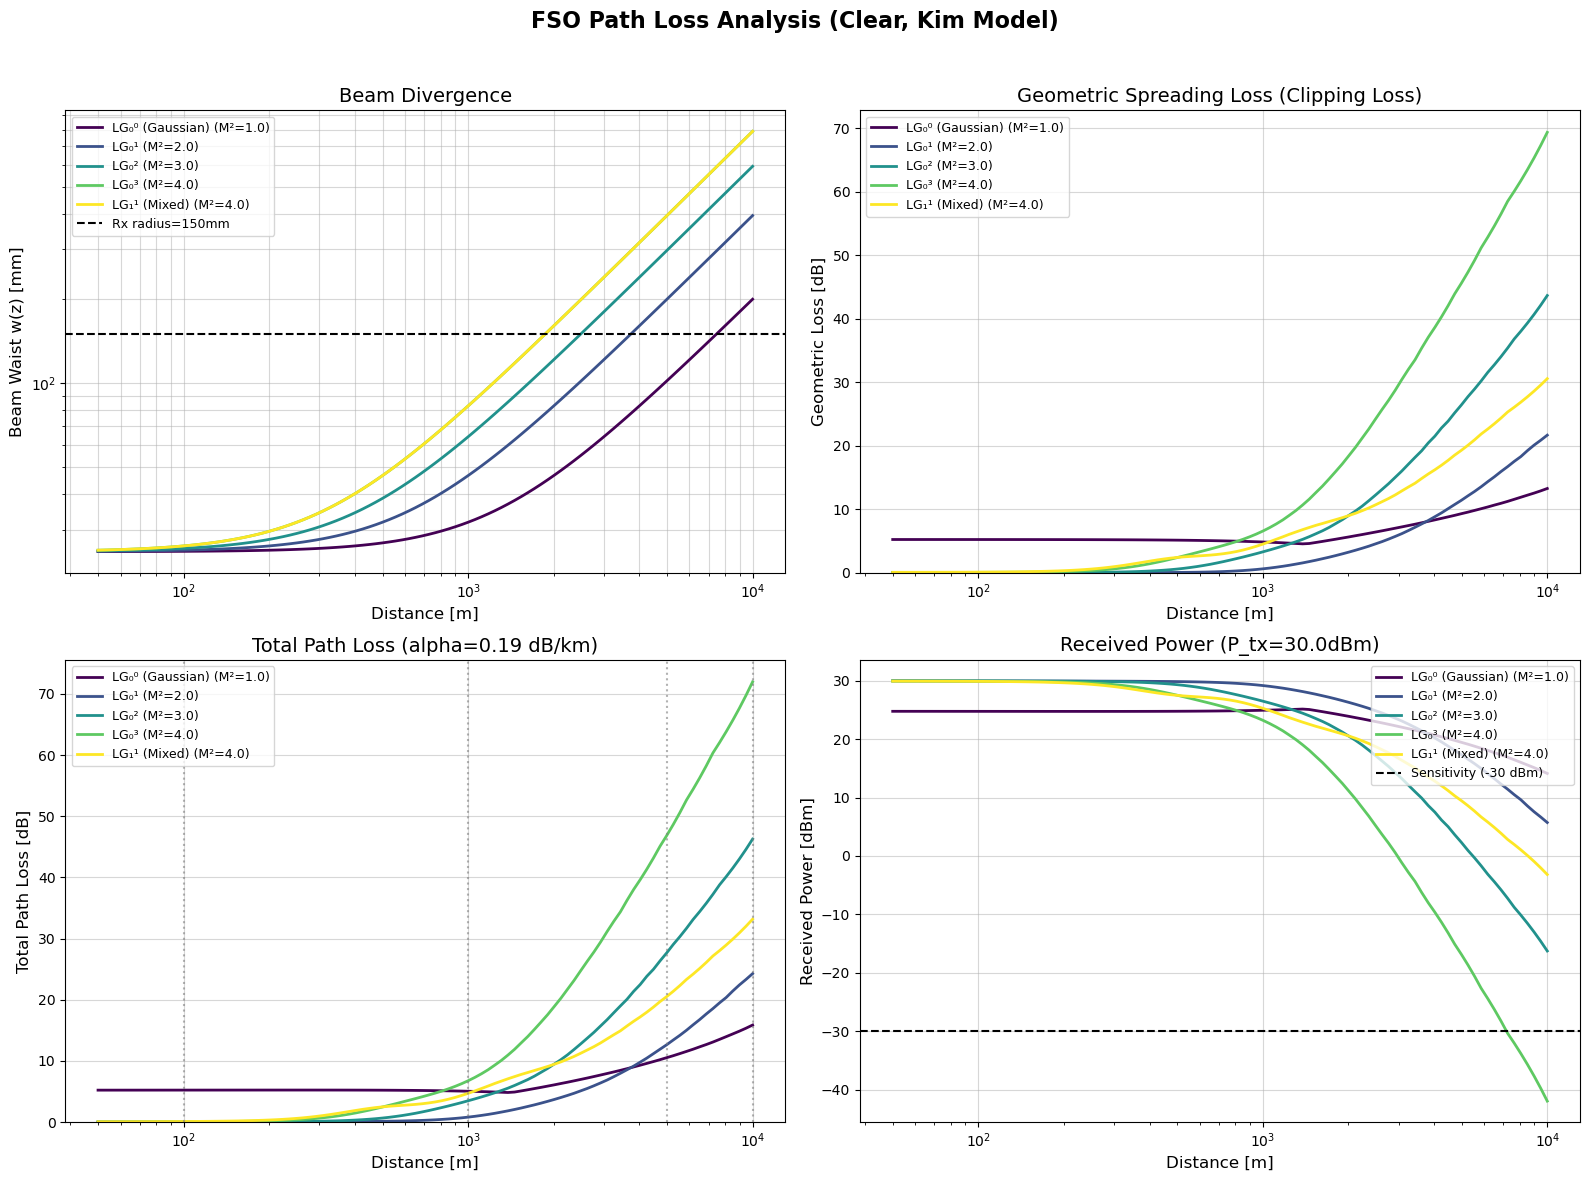

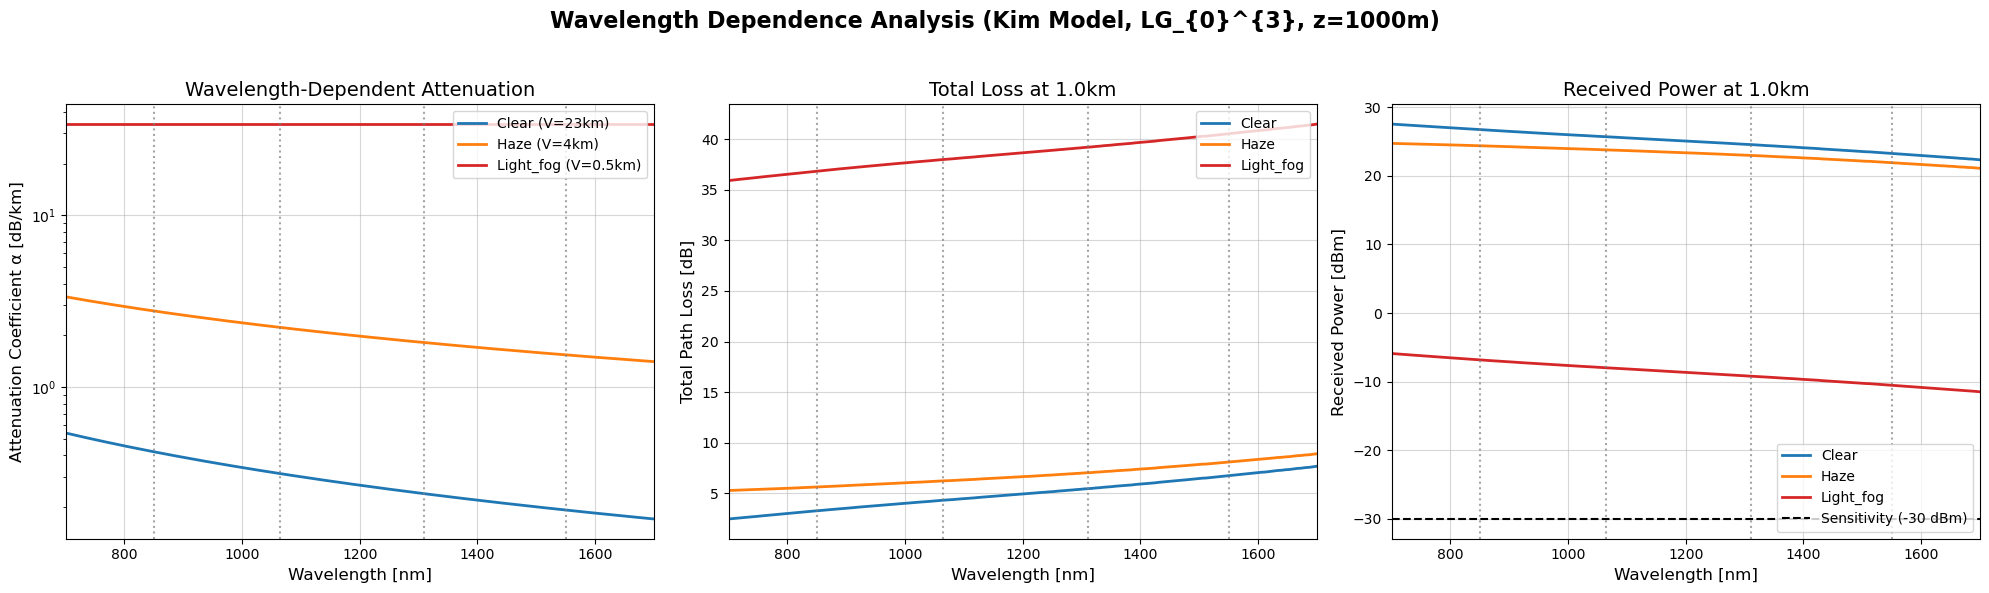

Done.


In [1]:
#!/usr/bin/env python3
"""
encoding_pathloss_tools.py

Patched FSO path-loss utilities for Laguerre-Gaussian beams.

Key fixes:
 - Accurate collection for LG modes: numeric radial integration of intensity.
 - Scintillation handled via aperture-averaged Rytov variance and log-normal approx.
 - Added helper to compute outage fade margin from σ_I^2 (log-normal approach).
 - Minor robustness fixes and clearer docstrings.

Usage:
 - Keep lgBeam.py in same directory (class LaguerreGaussianBeam must provide beam_waist(z)
   and ideally radial_intensity(r, z) or generate_beam_field(R, PHI, z) for best accuracy).
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings

try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
sys.path.insert(0, SCRIPT_DIR)

try:
    from lgBeam import LaguerreGaussianBeam
except ImportError:
    print(f"Error: Could not find 'lgBeam.py' in the script directory: {SCRIPT_DIR}")
    print("Please make sure the lgBeam.py file is saved in the same folder.")
    sys.exit(1)

warnings.filterwarnings('ignore')
np.random.seed(42)

PLOT_DIR = os.path.join(SCRIPT_DIR, "plots")
os.makedirs(PLOT_DIR, exist_ok=True)

# --------------------------
# Kim attenuation (unchanged)
# --------------------------
def calculate_kim_attenuation(wavelength_nm, visibility_km):
    """
    Kim model: α(λ) [1/km] = (3.91/V) * (λ/550nm)^(-q)
    Converts to dB/km by multiplying by 10*log10(e) ≈ 4.343.
    """
    if visibility_km <= 0:
        warnings.warn(f"Invalid visibility {visibility_km} km. Returning inf attenuation.")
        return np.inf

    if visibility_km > 50:
        q = 1.6
    elif visibility_km > 6:
        q = 1.3
    elif visibility_km > 1:
        q = 0.16 * visibility_km + 0.34
    elif visibility_km > 0.5:
        q = visibility_km - 0.5
    else:
        q = 0.0

    alpha_inv_km = (3.91 / visibility_km) * (float(wavelength_nm) / 550.0) ** (-q)
    alpha_dB_km = alpha_inv_km * (10.0 * np.log10(np.exp(1.0)))
    return alpha_dB_km

# ----------------------------------------------------
# Numeric collection fraction for LG modes (recommended)
# ----------------------------------------------------
def collection_fraction_numeric(beam, z, receiver_radius, n_r=4096, r_factor=8.0, n_phi=16):
    """
    Numerically compute fraction of total beam power captured by a circular aperture of radius
    receiver_radius at distance z for the given LaguerreGaussianBeam instance.

    Integration performed as:
      frac = (∫_{0}^{R_ap} 2π r I(r) dr) / (∫_{0}^{Rmax} 2π r I(r) dr)

    Strategy:
      - Prefer beam.radial_intensity(r, z) if implemented (fast).
      - Otherwise compute azimuthally-averaged radial intensity by sampling a small set of phi values
        and using beam.generate_beam_field(R, PHI, z) if available.

    Parameters:
    - beam: LaguerreGaussianBeam instance (must implement beam.beam_waist(z) and either radial_intensity or generate_beam_field)
    - z: propagation distance [m]
    - receiver_radius: aperture radius [m]
    - n_r: number of radial samples
    - r_factor: number of beam waists to use as Rmax (Rmax = r_factor * w_z)
    - n_phi: number of azimuth samples for averaging (if radial API absent)
    """
    # get beam waist
    try:
        w_z = float(beam.beam_waist(z))
    except Exception:
        # if beam can't provide waist, fallback to a sensible small value
        w_z = 1e-3

    if not np.isfinite(w_z) or w_z <= 0:
        return 0.0

    # choose Rmax large enough to capture rings; ensure at least a few receiver radii
    Rmax = max(r_factor * w_z, max(2.0 * receiver_radius, 8.0 * w_z, 1e-6))
    r = np.linspace(0.0, Rmax, n_r)
    dr = r[1] - r[0]

    # Try beam.radial_intensity(r,z) first (preferred)
    try:
        I_r_candidate = beam.radial_intensity(r, z)
        I_r = np.asarray(I_r_candidate, dtype=float).ravel()
        if I_r.size < r.size:
            # pad with small values
            pad = np.zeros(r.size - I_r.size, dtype=float)
            I_r = np.concatenate([I_r, pad])
    except Exception:
        # fallback: sample a phi stripe and average over phi numerically
        phi_vals = np.linspace(0, 2 * np.pi, n_phi, endpoint=False)
        I_r_acc = np.zeros_like(r, dtype=float)
        # Build arrays for sampling: for each phi compute field along r
        # We'll attempt to call generate_beam_field with R,PHI grids. Many implementations accept arrays.
        for phi in phi_vals:
            X = np.outer(r, np.cos(phi))  # shape (n_r,)
            Y = np.outer(r, np.sin(phi))
            # Many generate_beam_field signatures use (R, PHI, z, P_tx_watts=...) or (X, Y, z)
            F = None
            try:
                F = beam.generate_beam_field(X, Y, z)
            except Exception:
                try:
                    F = beam.generate_beam_field(X, Y, z, P_tx_watts=1.0)
                except Exception:
                    # If generate_beam_field doesn't accept X,Y we try polar signature R,PHI
                    try:
                        F = beam.generate_beam_field(r, np.full_like(r, phi), z)
                    except Exception:
                        raise RuntimeError(
                            "LaguerreGaussianBeam must implement radial_intensity(r,z) or generate_beam_field(R,PHI,z) / generate_beam_field(X,Y,z)."
                        )
            F = np.asarray(F)
            # reduce to radial profile (if 2D return, take appropriate axis)
            if F.ndim == 2:
                # if shape (n_r,1) or (1,n_r) -> reduce
                if F.shape[1] == 1:
                    fr = F[:, 0]
                elif F.shape[0] == 1:
                    fr = F[0, :]
                else:
                    # take first column (assuming sampling along rows)
                    fr = F[:, 0]
            else:
                fr = F.ravel()[: r.size]
            I_r_acc += np.abs(fr) ** 2
        I_r = I_r_acc / float(len(phi_vals))

    # Normalize total power (radial integral of 2π r I(r) dr)
    total = np.trapz(2.0 * np.pi * r * I_r, r)
    if total <= 0 or not np.isfinite(total):
        return 0.0

    # integrate inside receiver aperture
    mask = r <= receiver_radius
    if not np.any(mask):
        return 0.0
    collected = np.trapz(2.0 * np.pi * r[mask] * I_r[mask], r[mask])
    frac = float(collected / total)
    # clamp
    return max(0.0, min(1.0, frac))

# ------------------------------
# Geometric loss (uses numeric)
# ------------------------------
def calculate_geometric_loss(beam, z, receiver_radius, grid_size=501, extent_factor=4.0):
    """
    Compute geometric (clipping/collection) loss by numeric integration.
    - First tries the faster radial integration `collection_fraction_numeric`.
    - If that fails, falls back to a 2D grid via beam.calculate_intensity(R,PHI,z,...).

    Returns:
      (L_geo_dB, eta_collection)
    """
    # attempt radial integration (preferred)
    try:
        eta = collection_fraction_numeric(beam, z, receiver_radius, n_r=2048, r_factor=8.0, n_phi=16)
        eta = float(np.clip(eta, 0.0, 1.0))
        if eta <= 0:
            L_geo_dB = float('inf')
        else:
            L_geo_dB = -10.0 * np.log10(eta)
        return L_geo_dB, eta
    except Exception:
        # fallback to 2D evaluation (slower, but general)
        pass

    # 2D fallback
    try:
        w_z = beam.beam_waist(z)
    except Exception:
        w_z = 1e-3
    if w_z <= 0:
        return float('inf'), 0.0

    extent = extent_factor * w_z
    x = np.linspace(-extent, extent, grid_size)
    y = np.linspace(-extent, extent, grid_size)
    X, Y = np.meshgrid(x, y, indexing='xy')
    R = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y, X)

    # Try a couple of known APIs for intensity/field
    I = None
    try:
        I = np.asarray(beam.calculate_intensity(R, PHI, z, P_tx_watts=1.0), dtype=float)
    except Exception:
        try:
            # generate_beam_field -> complex field E, intensity = |E|^2
            E = beam.generate_beam_field(R, PHI, z)
            E = np.asarray(E)
            I = np.abs(E) ** 2
        except Exception as e:
            raise RuntimeError("LaguerreGaussianBeam must implement calculate_intensity(R,PHI,z) or generate_beam_field(R,PHI,z).") from e

    dA = (x[1] - x[0]) * (y[1] - y[0])
    total_power = np.nansum(I) * dA
    mask = R <= receiver_radius
    collected = np.nansum(I[mask]) * dA
    eta = float(np.clip(collected / (total_power + 1e-16), 0.0, 1.0))
    L_geo_dB = -10.0 * np.log10(eta + 1e-16)
    return L_geo_dB, eta

# ---------------------------------------
# Scintillation helper: outage margin
# ---------------------------------------
from scipy.stats import norm

def scintillation_outage_margin_db(Cn2, wavelength, z, receiver_diameter, outage_prob=0.01):
    """
    Given turbulence Cn2, wavelength [m], distance z [m], and receiver diameter [m],
    compute a conservative fade margin (dB) such that outage probability ~ outage_prob
    using log-normal approximation after aperture averaging.

    Returns positive dB number (fade margin to allocate).
    """
    if Cn2 is None or Cn2 <= 0:
        return 0.0

    k = 2.0 * np.pi / wavelength
    # Rytov variance (weak turbulence)
    sigma_I2 = 1.23 * Cn2 * (k ** (7.0 / 6.0)) * (z ** (11.0 / 6.0))
    # coherence radius r0 and aperture averaging
    r0 = (0.423 * (k ** 2) * Cn2 * z) ** (-3.0 / 5.0)
    D = receiver_diameter
    A = 1.0 + 0.54 * (D / r0) ** (7.0 / 6.0) if r0 > 0 else 1.0
    sigma_I2_eff = sigma_I2 / A if A > 0 else sigma_I2
    # log-normal parameters
    sigma_ln = np.sqrt(np.log(1.0 + sigma_I2_eff))
    mu_ln = -0.5 * sigma_ln ** 2
    # quantile for outage (negative tail)
    q = norm.ppf(outage_prob)
    # factor (linear) at outage quantile
    factor = np.exp(mu_ln + q * sigma_ln)
    fade_db = -10.0 * np.log10(factor + 1e-16)  # positive dB margin
    return float(np.maximum(0.0, fade_db))

# ---------------------------------------
# Path loss (geometric + atm + scintillation)
# ---------------------------------------
def calculate_path_loss(self, z, receiver_radius, P_tx=1.0, weather='clear', use_kim_model=False,
                        custom_alpha_dBkm=None, C_n2=None):
    """
    Calculates total path loss (geometric + atmospheric + scintillation) for an FSO link.
    This is designed to be monkey-patched onto LaguerreGaussianBeam.

    Returns dictionary with items:
      'L_geo_dB', 'L_atm_dB', 'L_scint_dB', 'L_total_dB', 'P_rx_W', 'P_rx_dBm',
      'eta_collection', 'beam_waist_m', 'weather', 'alpha_atm_dBkm', 'model', plus
      'sigma_I2', 'sigma_ln2', 'r0_m', 'A_aperture' for diagnostics.
    """
    weather_attenuation_dbkm = {
        'clear': 0.43, 'haze': 4.2, 'light_fog': 20,
        'moderate_fog': 42, 'dense_fog': 100
    }
    visibility_map_km = {
        'clear': 23, 'haze': 4, 'light_fog': 0.5,
        'moderate_fog': 0.2, 'dense_fog': 0.05
    }

    model_used = 'Empirical'
    if custom_alpha_dBkm is not None:
        alpha_atm_dBkm = float(custom_alpha_dBkm)
        model_used = 'Custom'
        weather_label = 'custom'
    elif use_kim_model and weather.lower() in visibility_map_km:
        visibility_km = visibility_map_km[weather.lower()]
        wavelength_nm = self.wavelength * 1e9
        alpha_atm_dBkm = calculate_kim_attenuation(wavelength_nm, visibility_km)
        model_used = 'Kim'
        weather_label = weather.lower()
    elif weather.lower() in weather_attenuation_dbkm:
        alpha_atm_dBkm = weather_attenuation_dbkm[weather.lower()]
        model_used = 'Empirical'
        weather_label = weather.lower()
    else:
        warnings.warn(f"Unknown weather '{weather}'; defaulting to clear.")
        alpha_atm_dBkm = weather_attenuation_dbkm['clear']
        model_used = 'Empirical (Default)'
        weather_label = 'clear'

    # Atmospheric loss linear with distance
    L_atm_dB = alpha_atm_dBkm * (z / 1000.0)

    # geometric collection/clipping (uses numeric collection)
    try:
        L_geo_dB, eta_collection = calculate_geometric_loss(self, z, receiver_radius)
    except Exception:
        L_geo_dB, eta_collection = float('inf'), 0.0

    # Scintillation handling: Rytov variance + aperture averaging -> log-normal parameters
    L_scint_dB = 0.0
    sigma_I2 = 0.0
    sigma_ln2 = 0.0
    r0 = np.inf
    A = 1.0
    if C_n2 is not None and np.isfinite(C_n2) and C_n2 > 0:
        k = 2.0 * np.pi / self.wavelength
        sigma_I2 = 1.23 * C_n2 * (k ** (7.0 / 6.0)) * (z ** (11.0 / 6.0))
        r0 = (0.423 * (k ** 2) * C_n2 * z) ** (-3.0 / 5.0)
        D = 2.0 * receiver_radius
        if r0 > 0:
            A = 1.0 + 0.54 * (D / r0) ** (7.0 / 6.0)
        else:
            A = 1.0
        sigma_I2_eff = sigma_I2 / A if A > 0 else sigma_I2
        sigma_ln2 = np.log(1.0 + np.maximum(0.0, sigma_I2_eff))
        # median multiplicative factor due to log-normal scintillation is exp(-0.5*sigma_ln2)
        # convert to equivalent positive dB loss (median loss)
        L_scint_dB = 10.0 * np.log10(np.exp(0.5 * sigma_ln2)) if sigma_ln2 > 0 else 0.0
    else:
        sigma_I2 = 0.0
        sigma_ln2 = 0.0
        r0 = np.inf
        A = 1.0
        L_scint_dB = 0.0

    # Total path loss (dB)
    L_total_dB = L_geo_dB + L_atm_dB + L_scint_dB
    if not np.isfinite(L_total_dB) or L_geo_dB == float('inf'):
        P_rx_W = 0.0
        P_rx_dBm = -np.inf
    else:
        P_rx_W = P_tx * (10.0 ** (-L_total_dB / 10.0))
        P_rx_dBm = 10.0 * np.log10(P_rx_W * 1000.0) if P_rx_W > 0 else -np.inf

    return {
        'L_geo_dB': L_geo_dB,
        'L_atm_dB': L_atm_dB,
        'L_scint_dB': L_scint_dB,
        'L_total_dB': L_total_dB,
        'P_rx_W': P_rx_W,
        'P_rx_dBm': P_rx_dBm,
        'eta_collection': eta_collection,
        'beam_waist_m': self.beam_waist(z),
        'weather': weather_label,
        'alpha_atm_dBkm': alpha_atm_dBkm,
        'model': model_used,
        'sigma_I2': float(sigma_I2),
        'sigma_ln2': float(sigma_ln2),
        'r0_m': float(r0),
        'A_aperture': float(A)
    }

# -----------------------------------------
# Link budget summary (unchanged except call)
# -----------------------------------------
def link_budget_summary(self, distances, receiver_diameter=0.2, P_tx=1.0, weather='clear',
                        use_kim_model=False, C_n2=None):
    """
    Prints formatted link budget summary table for multiple distances.
    This is monkey-patched onto LaguerreGaussianBeam.
    """
    receiver_radius = receiver_diameter / 2.0

    print(f"\nLINK BUDGET SUMMARY: LG_{self.p}^{self.l} Beam")
    print(f"Beam Parameters:")
    print(f"  M² = {self.M_squared:.1f} (beam quality factor)")
    print(f"  λ = {self.wavelength*1e9:.0f} nm (wavelength)")
    print(f"  w0 = {self.w0*1e3:.2f} mm (initial beam waist)")
    try:
        zR = self.z_R
    except Exception:
        zR = (np.pi * self.w0**2 / self.wavelength)
    print(f"  z_R = {zR:.1f} m (Rayleigh range)")

    if not distances:
        print("No distances provided for summary.")
        return

    test_result = self.calculate_path_loss(distances[0], receiver_radius, P_tx,
                                          weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
    print(f"\nLink Parameters:")
    print(f"  P_tx = {P_tx:.2f} W ({10.0*np.log10(P_tx*1000.0):.1f} dBm)")
    print(f"  Receiver diameter = {receiver_diameter*100.0:.1f} cm")
    print(f"  Weather Condition = {test_result['weather'].capitalize()}")
    print(f"  Attenuation model = {test_result['model']}")
    print(f"  alpha_atm = {test_result['alpha_atm_dBkm']:.2f} dB/km")
    if C_n2 is not None:
        print(f"  C_n2 = {C_n2:.0e} m^-2/3 (turbulence)")

    print(f"\n{'Distance':<12} {'w(z)':<10} {'eta_coll':<10} {'L_geo':<10} {'L_atm':<10} {'L_scint':<10} {'L_total':<10} {'P_rx':<15}")
    print(f"{'[m]':<12} {'[mm]':<10} {'[%]':<10} {'[dB]':<10} {'[dB]':<10} {'[dB]':<10} {'[dB]':<10} {'[dBm]':<15}")
    print("-"*110)
    for z in distances:
        result = self.calculate_path_loss(z, receiver_radius, P_tx,
                                         weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
        beam_w_mm = result['beam_waist_m']*1e3 if result['beam_waist_m'] is not None else float('nan')
        eta_pct = result['eta_collection']*100.0
        print(f"{z:<12.0f} {beam_w_mm:<10.2f} "
              f"{eta_pct:<10.1f} "
              f"{result['L_geo_dB']:<10.2f} {result['L_atm_dB']:<10.2f} "
              f"{result['L_scint_dB']:<10.2f} {result['L_total_dB']:<10.2f} {result['P_rx_dBm']:<15.2f}")

# Monkey-patch onto imported class
LaguerreGaussianBeam.calculate_path_loss = calculate_path_loss
LaguerreGaussianBeam.link_budget_summary = link_budget_summary

# -------------------------------
# plotting helpers (unchanged)
# -------------------------------
def plot_path_loss_analysis(beams_dict, distances=None, receiver_diameter=0.2,
                           P_tx=1.0, weather='clear', use_kim_model=False, C_n2=None):
    if distances is None:
        distances = np.logspace(np.log10(10), np.log10(10000), 100)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f"FSO Path Loss Analysis ({weather.capitalize()}, {('Kim' if use_kim_model else 'Empirical')} Model)",
                 fontsize=16, fontweight='bold')
    receiver_radius = receiver_diameter / 2.0
    colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(beams_dict))))
    if not beams_dict:
        print("No beams provided to plot_path_loss_analysis.")
        return fig
    test_beam = list(beams_dict.values())[0]
    result = test_beam.calculate_path_loss(1000, receiver_radius, P_tx,
                                          weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)
    alpha_atm = result['alpha_atm_dBkm']
    model_name = result['model']

    ax1 = axes[0, 0]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        w_z = np.array([beam.beam_waist(z) for z in distances])
        ax1.loglog(distances, w_z*1e3, linewidth=2.0,
                  label=f'{name} (M²={beam.M_squared:.1f})',
                  color=colors[idx])
    ax1.axhline(receiver_radius*1e3, color='k', linestyle='--',
               linewidth=1.5, label=f'Rx radius={receiver_radius*1e3:.0f}mm')
    ax1.set_xlabel('Distance [m]', fontsize=12)
    ax1.set_ylabel('Beam Waist w(z) [mm]', fontsize=12)
    ax1.set_title('Beam Divergence', fontsize=14)
    ax1.legend(fontsize=9, loc='upper left')
    ax1.grid(True, alpha=0.5, which='both')

    ax2 = axes[0, 1]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        L_geo = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx)['L_geo_dB']
                         for z in distances])
        ax2.semilogx(distances, L_geo, linewidth=2.0,
                    label=f'{name} (M²={beam.M_squared:.1f})',
                    color=colors[idx])
    ax2.set_xlabel('Distance [m]', fontsize=12)
    ax2.set_ylabel('Geometric Loss [dB]', fontsize=12)
    ax2.set_title('Geometric Spreading Loss (Clipping Loss)', fontsize=14)
    ax2.legend(fontsize=9, loc='upper left')
    ax2.grid(True, alpha=0.5, which='major')
    ax2.set_ylim(bottom=0)

    ax3 = axes[1, 0]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        L_total = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx,
                           weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)['L_total_dB']
                           for z in distances])
        ax3.semilogx(distances, L_total, linewidth=2.0,
                    label=f'{name} (M²={beam.M_squared:.1f})',
                    color=colors[idx])
    for dist, label in [(100, '100m'), (1000, '1km'), (5000, '5km'), (10000, '10km')]:
        if dist <= distances[-1]:
             ax3.axvline(dist, color='gray', linestyle=':', alpha=0.6)
    ax3.set_xlabel('Distance [m]', fontsize=12)
    ax3.set_ylabel('Total Path Loss [dB]', fontsize=12)
    ax3.set_title(f'Total Path Loss (alpha={alpha_atm:.2f} dB/km)', fontsize=14)
    ax3.legend(fontsize=9, loc='upper left')
    ax3.grid(True, alpha=0.5, which='major')
    ax3.set_ylim(bottom=max(0, ax3.get_ylim()[0]))

    ax4 = axes[1, 1]
    for idx, (name, beam) in enumerate(beams_dict.items()):
        P_rx_dBm = np.array([beam.calculate_path_loss(z, receiver_radius, P_tx,
                         weather=weather, use_kim_model=use_kim_model, C_n2=C_n2)['P_rx_dBm']
                         for z in distances])
        ax4.semilogx(distances, P_rx_dBm, linewidth=2.0,
                   label=f'{name} (M²={beam.M_squared:.1f})',
                   color=colors[idx])
    P_sensitivity_dBm = -30
    ax4.axhline(P_sensitivity_dBm, color='k', linestyle='--',
               linewidth=1.5, label=f'Sensitivity ({P_sensitivity_dBm} dBm)')
    ax4.set_xlabel('Distance [m]', fontsize=12)
    ax4.set_ylabel('Received Power [dBm]', fontsize=12)
    ax4.set_title(f'Received Power (P_tx={10*np.log10(P_tx*1000):.1f}dBm)', fontsize=14)
    ax4.legend(fontsize=9, loc='upper right')
    ax4.grid(True, alpha=0.5, which='major')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# <-- RECTIFIED: Added oam_mode_p=0
def wavelength_sweep_analysis(wavelengths_nm, oam_mode_p=0, oam_mode_l=1, distance_m=1000,
                              weather_conditions=['clear', 'haze', 'light_fog'],
                              w0=1e-3, receiver_diameter=0.2, P_tx=1.0, C_n2=None):
    visibility_map_km = {
        'clear': 23, 'haze': 4, 'light_fog': 0.5,
        'moderate_fog': 0.2, 'dense_fog': 0.05
    }
    results = {}
    print(f"\nRunning Wavelength Sweep Analysis (p={oam_mode_p}, l={oam_mode_l}, z={distance_m}m).")
    for weather in weather_conditions:
        if weather not in visibility_map_km:
            print(f"Skipping unknown weather '{weather}' for wavelength sweep.")
            continue
        visibility_km = visibility_map_km[weather]
        print(f"  Condition: {weather.capitalize()} (Visibility = {visibility_km} km)")
        alpha_values_dbkm = []
        L_total_values_dB = []
        P_rx_values_dBm = []
        for wavelength_nm in wavelengths_nm:
            wavelength = wavelength_nm * 1e-9
            beam = LaguerreGaussianBeam(p=oam_mode_p, l=oam_mode_l, wavelength=wavelength, w0=w0)
            alpha_dbkm = calculate_kim_attenuation(wavelength_nm, visibility_km)
            alpha_values_dbkm.append(alpha_dbkm)
            result = beam.calculate_path_loss(
                z=distance_m,
                receiver_radius=receiver_diameter/2.0,
                P_tx=P_tx,
                weather='custom',
                use_kim_model=False,
                custom_alpha_dBkm=alpha_dbkm,
                C_n2=C_n2
            )
            L_total_values_dB.append(result['L_total_dB'])
            P_rx_values_dBm.append(result['P_rx_dBm'])
        results[weather] = {
            'alpha_dBkm': np.array(alpha_values_dbkm),
            'L_total_dB': np.array(L_total_values_dB),
            'P_rx_dBm': np.array(P_rx_values_dBm),
            'visibility_km': visibility_km
        }
    return results

# <-- RECTIFIED: Added oam_mode_p=0, LaTeX title
def plot_wavelength_sweep(wavelengths_nm, results, oam_mode_p=0, oam_mode_l=1, distance_m=1000):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(rf"Wavelength Dependence Analysis (Kim Model, LG_{{{oam_mode_p}}}^{{{oam_mode_l}}}, z={distance_m}m)",
                 fontsize=16, fontweight='bold')

    colors = {'clear': 'tab:blue', 'haze': 'tab:orange', 'light_fog': 'tab:red',
              'moderate_fog': 'tab:purple', 'dense_fog': 'tab:brown'}
    common_wavelengths_nm = [850, 1064, 1310, 1550]

    ax1 = axes[0]
    for weather, data in results.items():
        ax1.plot(wavelengths_nm, data['alpha_dBkm'], linewidth=2.0,
                label=f"{weather.capitalize()} (V={data['visibility_km']}km)",
                color=colors.get(weather, 'black'))
    ymin1, ymax1 = ax1.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax1.axvline(wl, color='gray', linestyle=':', alpha=0.7)
            ax1.annotate(f'{wl}nm', xy=(wl, ymin1 + (ymax1-ymin1)*0.02), xytext=(10, 0),
                         textcoords='offset points', rotation=90, va='bottom', ha='left',
                         fontsize=9, color='dimgray')
    ax1.set_xlabel('Wavelength [nm]', fontsize=12)
    ax1.set_ylabel('Attenuation Coefficient α [dB/km]', fontsize=12)
    ax1.set_title('Wavelength-Dependent Attenuation', fontsize=14)
    ax1.legend(fontsize=10, loc='upper right')
    ax1.grid(True, alpha=0.5)
    ax1.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    ax1.set_yscale('log')
    ax2 = axes[1]
    for weather, data in results.items():
        ax2.plot(wavelengths_nm, data['L_total_dB'], linewidth=2.0,
                label=f"{weather.capitalize()}",
                color=colors.get(weather, 'black'))
    ymin2, ymax2 = ax2.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax2.axvline(wl, color='gray', linestyle=':', alpha=0.7)
    ax2.set_xlabel('Wavelength [nm]', fontsize=12)
    ax2.set_ylabel('Total Path Loss [dB]', fontsize=12)
    ax2.set_title(f'Total Loss at {distance_m/1000.0:.1f}km', fontsize=14)
    ax2.legend(fontsize=10, loc='upper right')
    ax2.grid(True, alpha=0.5)
    ax2.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    ax3 = axes[2]
    for weather, data in results.items():
        ax3.plot(wavelengths_nm, data['P_rx_dBm'], linewidth=2.0,
                label=f"{weather.capitalize()}",
                color=colors.get(weather, 'black'))
    P_sensitivity_dBm = -30
    ax3.axhline(P_sensitivity_dBm, color='k', linestyle='--', linewidth=1.5,
               label=f'Sensitivity ({P_sensitivity_dBm} dBm)')
    ymin3, ymax3 = ax3.get_ylim()
    for wl in common_wavelengths_nm:
        if wavelengths_nm[0] <= wl <= wavelengths_nm[-1]:
            ax3.axvline(wl, color='gray', linestyle=':', alpha=0.7)
    ax3.set_xlabel('Wavelength [nm]', fontsize=12)
    ax3.set_ylabel('Received Power [dBm]', fontsize=12)
    ax3.set_title(f'Received Power at {distance_m/1000.0:.1f}km', fontsize=14)
    ax3.legend(fontsize=10, loc='lower right')
    ax3.grid(True, alpha=0.5)
    ax3.set_xlim(wavelengths_nm[0], wavelengths_nm[-1])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

if __name__ == "__main__":
    # --- Define Simulation Parameters ---
    WAVELENGTH = 1550e-9
    W0 = 25e-3
    RECEIVER_DIAMETER = 0.3
    P_TX = 1.0
    DISTANCES = [100, 500, 1000, 2000, 5000]
    WEATHER = 'clear' # Options: 'clear', 'haze', 'light_fog', 'moderate_fog', 'dense_fog'
    USE_KIM_MODEL = True
    C_N2 = 1e-15  # Example weak turb; set None for no scint
    WAVELENGTH_SWEEP_RANGE = np.linspace(700, 1700, 150)
    WEATHER_CONDITIONS = ['clear', 'haze', 'light_fog']

    print("CONFIGURATION:")
    print(f"  Wavelength:        {WAVELENGTH*1e9:.0f} nm")
    print(f"  Beam waist:        {W0*1e3:.1f} mm")
    print(f"  Transmit power:    {P_TX:.1f} W ({10*np.log10(P_TX*1000):.1f} dBm)")
    print(f"  Receiver diameter: {RECEIVER_DIAMETER*100:.1f} cm")
    print(f"  Weather (for dist):{WEATHER.capitalize()}")
    print(f"  Model (for dist):  {'Kim' if USE_KIM_MODEL else 'Empirical'}")
    if C_N2 is not None:
        print(f"  C_n2 (turb):       {C_N2:.0e} m^{-2/3}")

    # --- This 'beams' dictionary is already general and tests (p,l) modes ---
    beams = {
        "LG₀⁰ (Gaussian)": LaguerreGaussianBeam(0, 0, WAVELENGTH, W0),
        "LG₀¹": LaguerreGaussianBeam(0, 1, WAVELENGTH, W0),
        "LG₀²": LaguerreGaussianBeam(0, 2, WAVELENGTH, W0),
        "LG₀³": LaguerreGaussianBeam(0, 3, WAVELENGTH, W0),
        "LG₁¹ (Mixed)": LaguerreGaussianBeam(1, 1, WAVELENGTH, W0),
    }

    beams_to_summarize = ["LG₀⁰ (Gaussian)", "LG₀²", "LG₁¹ (Mixed)"]
    for name in beams_to_summarize:
        if name in beams:
            beams[name].link_budget_summary(DISTANCES, RECEIVER_DIAMETER, P_TX, WEATHER, USE_KIM_MODEL, C_n2=C_N2)
        else:
            print(f"Warning: Beam '{name}' not found for summary.")

    print("\nCOMPARISON AT SPECIFIC DISTANCE")

    z_test = 1000
    weather_test = WEATHER
    model_test = USE_KIM_MODEL

    test_result = beams[list(beams.keys())[0]].calculate_path_loss(
        z_test, RECEIVER_DIAMETER/2, P_tx=P_TX, weather=weather_test, use_kim_model=model_test, C_n2=C_N2
    )
    alpha_used = test_result['alpha_atm_dBkm']
    model_name = test_result['model']
    print(f"Conditions: z = {z_test}m, Weather = {weather_test.capitalize()}, Model = {model_name}, alpha = {alpha_used:.2f} dB/km")
    print("-"*110)
    print(f"{'Beam Mode':<25} {'M²':<6} {'L_geo [dB]':<12} {'L_atm [dB]':<12} {'L_scint [dB]':<12} {'L_total [dB]':<14} {'P_rx [dBm]':<12}")
    print("-"*110)
    for name, beam in beams.items():
        result = beam.calculate_path_loss(z_test, RECEIVER_DIAMETER/2, P_TX,
                                         weather=weather_test, use_kim_model=model_test, C_n2=C_N2)
        print(f"{name:<25} {beam.M_squared:<6.1f} {result['L_geo_dB']:>10.2f}  "
              f"{result['L_atm_dB']:>10.2f}  {result['L_scint_dB']:>10.2f}  "
              f"{result['L_total_dB']:>12.2f}  {result['P_rx_dBm']:>10.2f}")

    print("\nGenerating plots...")
    fig1 = plot_path_loss_analysis(beams, distances=np.logspace(np.log10(50), np.log10(10000), 100),
                                   receiver_diameter=RECEIVER_DIAMETER,
                                   P_tx=P_TX, weather=WEATHER, use_kim_model=USE_KIM_MODEL, C_n2=C_N2)
    path_loss_fig_path = os.path.join(PLOT_DIR, f'oam_path_loss_{WEATHER}_{"kim" if USE_KIM_MODEL else "emp"}{"_turb" if C_N2 else ""}.png')
    fig1.savefig(path_loss_fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved path loss plot to {path_loss_fig_path}")

    sweep_results = wavelength_sweep_analysis(
        wavelengths_nm=WAVELENGTH_SWEEP_RANGE,
        oam_mode_p=0,
        oam_mode_l=3,
        distance_m=1000,
        weather_conditions=WEATHER_CONDITIONS,
        w0=W0,
        receiver_diameter=RECEIVER_DIAMETER,
        P_tx=P_TX,
        C_n2=C_N2
    )
    fig2 = plot_wavelength_sweep(WAVELENGTH_SWEEP_RANGE, sweep_results,
                                 oam_mode_p=0, oam_mode_l=3, distance_m=1000)
    wavelength_fig_path = os.path.join(PLOT_DIR, f'wavelength_sweep_p0_l3_1km{"_turb" if C_N2 else ""}.png')
    fig2.savefig(wavelength_fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved wavelength sweep plot to {wavelength_fig_path}")

    plt.show()
    print("Done.")